
 POLICY GRADIENT (REINFORCE) ===
Episodio 0: Recompensa = 11.0, Media = 11.0
Episodio 50: Recompensa = 13.0, Media = 24.1
Episodio 100: Recompensa = 24.0, Media = 34.7
Episodio 150: Recompensa = 112.0, Media = 61.3
Episodio 200: Recompensa = 103.0, Media = 88.7
Episodio 250: Recompensa = 217.0, Media = 118.0
Episodio 300: Recompensa = 160.0, Media = 122.9
Episodio 350: Recompensa = 157.0, Media = 253.4
Episodio 400: Recompensa = 369.0, Media = 243.0
Episodio 450: Recompensa = 419.0, Media = 390.1
Episodio 500: Recompensa = 376.0, Media = 342.0
Episodio 550: Recompensa = 500.0, Media = 441.1
Episodio 600: Recompensa = 500.0, Media = 423.0
Episodio 650: Recompensa = 268.0, Media = 386.9
Episodio 700: Recompensa = 500.0, Media = 445.7
Episodio 750: Recompensa = 288.0, Media = 391.6
Episodio 800: Recompensa = 500.0, Media = 456.7
Episodio 850: Recompensa = 500.0, Media = 469.5
Episodio 900: Recompensa = 500.0, Media = 465.5
Episodio 950: Recompensa = 500.0, Media = 464.1
Episodio 1000: Re

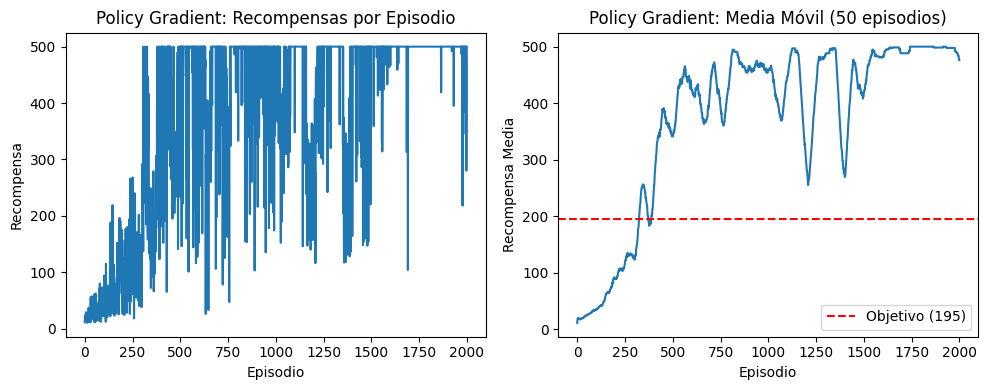

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# =============================================================================
# EJEMPLO 2: POLICY GRADIENT (REINFORCE) - APRENDE POLÍTICA DIRECTAMENTE  
# =============================================================================

print("\n POLICY GRADIENT (REINFORCE) ===")

import torch
import torch.nn as nn

class RedPolicy(nn.Module):
    def __init__(self, dim_entrada, dim_salida):
        super().__init__()
        # Red simple: estado -> probabilidades de acciones
        self.capa1 = nn.Linear(dim_entrada, 128)
        self.capa2 = nn.Linear(128, dim_salida)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = torch.relu(self.capa1(x))
        x = self.softmax(self.capa2(x))
        return x

class AgentePolicyGradient:
    def __init__(self, dim_entrada, dim_salida, lr=0.01, gamma=0.99):
        self.policy_net = RedPolicy(dim_entrada, dim_salida)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        self.gamma = gamma
        
        # Guardar experiencias del episodio
        self.log_probs = []  # log(π(a|s)) - probabilidad de acciones tomadas
        self.recompensas = []  # recompensas obtenidas
    
    def elegir_accion(self, estado):
        estado_tensor = torch.FloatTensor(estado)
        probabilidades = self.policy_net(estado_tensor)
        
        # Distribución categórica basada en probabilidades
        distribucion = torch.distributions.Categorical(probabilidades)
        accion = distribucion.sample()
        log_prob = distribucion.log_prob(accion)
        
        self.log_probs.append(log_prob)
        return accion.item()
    
    def actualizar_policy(self):
        # CALCULAR RETORNOS DESCONTADOS: G_t = Σ γ^k * r_{t+k}
        retornos = []
        R = 0
        for r in self.recompensas[::-1]:  # Del final al inicio
            R = r + self.gamma * R
            retornos.insert(0, R)
        
        retornos = torch.FloatTensor(retornos)
        
        # POLICY GRADIENT: ∇J(θ) = E[∇logπ(a|s) * G]
        perdida = []
        for log_prob, G in zip(self.log_probs, retornos):
            perdida.append(-log_prob * G)  # Negativo porque maximizamos
        
        # Backpropagation
        self.optimizer.zero_grad()
        perdida_total = torch.stack(perdida).sum()
        perdida_total.backward()
        self.optimizer.step()
        
        # Limpiar memoria del episodio
        self.log_probs = []
        self.recompensas = []

def entrenar_policy_gradient():
    # CartPole: equilibrar péndulo en carrito
    env = gym.make('CartPole-v1')
    
    agente = AgentePolicyGradient(
        dim_entrada=4,   # [posición, velocidad, ángulo, velocidad angular]
        dim_salida=2,    # 0: empujar izquierda, 1: empujar derecha
        lr=0.001,
        gamma=0.99
    )
    
    recompensas_totales = []
    
    for episodio in range(2000):
        estado, _ = env.reset()
        recompensa_episodio = 0
        terminado = False
        truncado = False
        
        while not (terminado or truncado):
            accion = agente.elegir_accion(estado)
            siguiente_estado, recompensa, terminado, truncado, _ = env.step(accion)
            
            agente.recompensas.append(recompensa)
            estado = siguiente_estado
            recompensa_episodio += recompensa
        
        # Actualizar política después del episodio completo
        agente.actualizar_policy()
        recompensas_totales.append(recompensa_episodio)
        
        if episodio % 50 == 0:
            media_actual = np.mean(recompensas_totales[-50:]) if len(recompensas_totales) >= 50 else np.mean(recompensas_totales)
            print(f"Episodio {episodio}: Recompensa = {recompensa_episodio}, Media = {media_actual:.1f}")
    
    env.close()
    
    # Gráfico
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(recompensas_totales)
    plt.title('Policy Gradient: Recompensas por Episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    
    plt.subplot(1, 2, 2)
    media_movil = [np.mean(recompensas_totales[max(0,i-49):i+1]) for i in range(len(recompensas_totales))]
    plt.plot(media_movil)
    plt.title('Policy Gradient: Media Móvil (50 episodios)')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa Media')
    plt.axhline(y=195, color='r', linestyle='--', label='Objetivo (195)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return agente

# Ejecutar Policy Gradient
agente_pg = entrenar_policy_gradient()

🎯 POLICY GRADIENT TABULAR - MUNDO 10x10
🎯 ENTRENANDO POLICY GRADIENT TABULAR
Episodio   0 | Recompensa:  -3.60 | Media:  -3.60
Episodio  50 | Recompensa:  15.60 | Media:   8.12
Episodio 100 | Recompensa:  40.50 | Media:  29.82
Episodio 150 | Recompensa:  25.80 | Media:  34.07
Episodio 200 | Recompensa:  29.80 | Media:  36.04
Episodio 250 | Recompensa:  38.20 | Media:  34.55

🎬 DEMOSTRACIÓN FINAL - POLICY GRADIENT
  Grabando episodio demostración 1...
  Grabando episodio demostración 2...
  Grabando episodio demostración 3...
✅ Demostración final grabada

🔄 CREANDO GIFS...
  ✅ entrenamiento_policy_episodio_000.gif
  ✅ entrenamiento_policy_episodio_050.gif
  ✅ entrenamiento_policy_episodio_100.gif
  ✅ entrenamiento_policy_episodio_150.gif
  ✅ entrenamiento_policy_episodio_200.gif
  ✅ entrenamiento_policy_episodio_250.gif
  ✅ entrenamiento_policy_episodio_299.gif
  ✅ demo_policy_episodio_000.gif
  ✅ demo_policy_episodio_001.gif
  ✅ demo_policy_episodio_002.gif
✅ Todos los GIFs creados

📊 

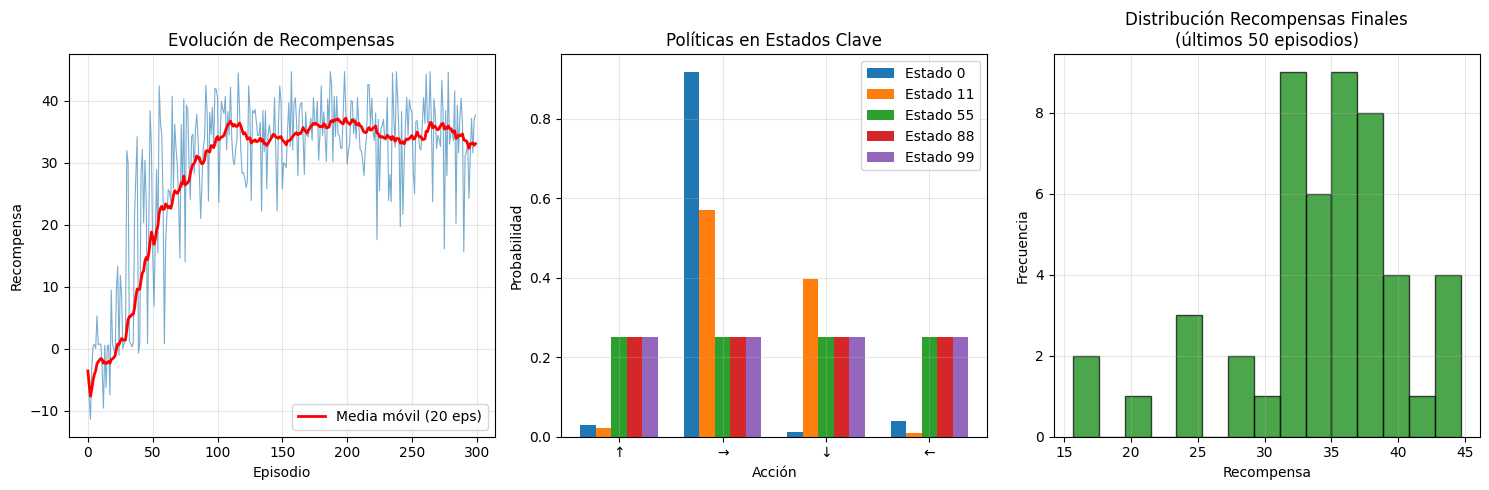

📈 ESTADÍSTICAS FINALES:
   • Episodios totales: 300
   • Recompensa promedio: 29.34
   • Mejor recompensa: 44.70
   • Recompensa promedio (últimos 50): 34.27
   • Tasa de éxito (recompensa > 5): 89.3%

✅ PROGRAMA COMPLETADO
   • Tiempo total: 106.2 segundos
   • Archivos generados:
     - policy_gradient_tabular/ (entrenamiento)
     - policy_final_demo/ (demostración)
     - entrenamiento_policy_episodio_XXX.gif
     - demo_policy_episodio_XXX.gif
     - resultados_policy_gradient_tabular.png


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import time

# =============================================================================
# AMBIENTE 10x10
# =============================================================================

class GridWorld10x10:
    def __init__(self):
        self.size = 10
        self.meta = (9, 9)
        self.inicio = (0, 0)
        self.estado_actual = self.inicio
        
        self.obstaculos = [
            (2, 2), (2, 3), (2, 4),
            (5, 5), (5, 6), (5, 7), (5, 8),
            (7, 1), (7, 2), (7, 3),
            (8, 6), (8, 7), (9, 6)
        ]
        
        self.premios = {
            (3, 3): 2,
            (6, 2): 3,  
            (8, 8): 5,
        }
        
    def reset(self):
        self.estado_actual = self.inicio
        return self.estado_actual
        
    def step(self, accion):
        fila, col = self.estado_actual
        fila_anterior, col_anterior = fila, col
        
        if accion == 0 and fila > 0:
            fila -= 1
        elif accion == 1 and col < self.size - 1:
            col += 1
        elif accion == 2 and fila < self.size - 1:
            fila += 1
        elif accion == 3 and col > 0:
            col -= 1
        
        nuevo_estado = (fila, col)
        
        if nuevo_estado in self.obstaculos:
            nuevo_estado = (fila_anterior, col_anterior)
            recompensa = -2
        elif nuevo_estado in self.premios:
            recompensa = self.premios[nuevo_estado]
        elif nuevo_estado == self.meta:
            recompensa = 10
        else:
            distancia_anterior = abs(fila_anterior - 9) + abs(col_anterior - 9)
            distancia_actual = abs(fila - 9) + abs(col - 9)
            
            if distancia_actual < distancia_anterior:
                recompensa = 0.1
            elif distancia_actual > distancia_anterior:
                recompensa = -0.1
            else:
                recompensa = -0.05
        
        self.estado_actual = nuevo_estado
        terminado = (nuevo_estado == self.meta)
        
        return nuevo_estado, recompensa, terminado, False, {}
    
    def get_estado_index(self, estado):
        fila, col = estado
        return fila * self.size + col

# =============================================================================
# POLICY GRADIENT VERDADERO - TABLA DE PROBABILIDADES
# =============================================================================

class AgentePolicyGradientTabular:
    def __init__(self, n_estados, n_acciones, alpha=0.1, gamma=0.99):
        self.n_estados = n_estados
        self.n_acciones = n_acciones
        self.alpha = alpha  # Tasa de aprendizaje para políticas
        self.gamma = gamma  # Factor de descuento
        
        # TABLA DE POLÍTICAS: π(s,a) = probabilidad de tomar acción a en estado s
        # Inicialmente uniforme
        self.policy_table = np.ones((n_estados, n_acciones)) / n_acciones
        
        # Memoria del episodio actual
        self.episodio_estados = []
        self.episodio_acciones = []
        self.episodio_recompensas = []
    
    def seleccionar_accion(self, estado_index):
        """Seleccionar acción según la política actual π(s)"""
        probabilidades = self.policy_table[estado_index]
        accion = np.random.choice(self.n_acciones, p=probabilidades)
        return accion
    
    def guardar_experiencia(self, estado_index, accion, recompensa):
        """Guardar experiencia del paso actual"""
        self.episodio_estados.append(estado_index)
        self.episodio_acciones.append(accion)
        self.episodio_recompensas.append(recompensa)
    
    def actualizar_politica(self):
        """ACTUALIZAR POLÍTICA usando Policy Gradient Monte Carlo"""
        if not self.episodio_estados:
            return
            
        T = len(self.episodio_estados)
        
        # Calcular retornos G_t para cada paso t
        G = np.zeros(T)
        G[T-1] = self.episodio_recompensas[T-1]
        
        for t in range(T-2, -1, -1):
            G[t] = self.episodio_recompensas[t] + self.gamma * G[t+1]
        
        # Normalizar retornos para estabilidad
        if np.std(G) > 0:
            G = (G - np.mean(G)) / np.std(G)
        
        # ACTUALIZAR TABLA DE POLÍTICAS
        for t in range(T):
            estado = self.episodio_estados[t]
            accion = self.episodio_acciones[t]
            retorno = G[t]
            
            # Obtener probabilidades actuales para este estado
            probabilidades_actuales = self.policy_table[estado].copy()
            
            # Policy Gradient: ∇J(θ) ≈ G_t * ∇log π(a|s)
            # Actualización: θ ← θ + α * G_t * ∇log π(a|s)
            
            # Para cada acción en este estado
            for a in range(self.n_acciones):
                if a == accion:
                    # Acción tomada: aumentar probabilidad
                    self.policy_table[estado, a] += self.alpha * retorno * (1 - probabilidades_actuales[a])
                else:
                    # Otras acciones: disminuir probabilidad
                    self.policy_table[estado, a] -= self.alpha * retorno * probabilidades_actuales[a]
            
            # Asegurar que las probabilidades sean válidas
            self.policy_table[estado] = np.clip(self.policy_table[estado], 0.01, 0.99)
            self.policy_table[estado] /= np.sum(self.policy_table[estado])
        
        # Limpiar memoria del episodio
        self.episodio_estados = []
        self.episodio_acciones = []
        self.episodio_recompensas = []
    
    def get_politica_estado(self, estado_index):
        """Obtener política para un estado específico"""
        return self.policy_table[estado_index]

# =============================================================================
# VISUALIZACIÓN
# =============================================================================

def crear_visualizacion_policy(env, agente, episodio, paso, accion=None):
    """Crear visualización que muestre la política"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # ===========================================
    # SUBPLOT 1: MAPA DEL GRID
    # ===========================================
    grid_colores = np.zeros((env.size, env.size, 3))
    grid_colores[:, :, 1] = 0.8  # Verde claro base
    
    # Colorear elementos
    for obs in env.obstaculos:
        grid_colores[obs] = [0.5, 0.5, 0.5]  # Gris
    for premio_pos in env.premios:
        grid_colores[premio_pos] = [1.0, 1.0, 0.0]  # Amarillo
    grid_colores[env.meta] = [0.0, 0.0, 1.0]  # Azul
    grid_colores[env.estado_actual] = [1.0, 0.0, 0.0]  # Rojo
    
    ax1.imshow(grid_colores)
    
    # Añadir texto
    accion_texto = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    accion_str = accion_texto.get(accion, 'Inicio')
    ax1.set_title(f'Policy Gradient - Episodio: {episodio}, Paso: {paso}\nAcción: {accion_str}', fontsize=14)
    
    # Símbolos
    for i in range(env.size):
        for j in range(env.size):
            texto = ""
            color = "white"
            if (i, j) == env.estado_actual:
                texto = "X"
            elif (i, j) == env.meta:
                texto = "G"
            elif (i, j) in env.obstaculos:
                texto = "█"
            elif (i, j) in env.premios:
                texto = str(env.premios[(i, j)])
                color = "black"
            
            if texto:
                ax1.text(j, i, texto, ha='center', va='center', 
                        fontsize=10, fontweight='bold', color=color)
    
    ax1.set_xticks(range(env.size))
    ax1.set_yticks(range(env.size))
    ax1.grid(True, alpha=0.3)
    
    # ===========================================
    # SUBPLOT 2: POLÍTICA ACTUAL
    # ===========================================
    estado_actual_idx = env.get_estado_index(env.estado_actual)
    politica_actual = agente.get_politica_estado(estado_actual_idx)
    
    acciones = ['↑ ARRIBA', '→ DERECHA', '↓ ABAJO', '← IZQUIERDA']
    colores = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
    
    bars = ax2.barh(acciones, politica_actual, color=colores, alpha=0.7)
    ax2.set_title('POLÍTICA π(a|s)\nProbabilidades por Acción', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Probabilidad')
    ax2.set_xlim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    # Añadir valores en las barras
    for bar, valor in zip(bars, politica_actual):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{valor:.3f}', va='center', fontweight='bold')
    
    # Destacar la acción con mayor probabilidad
    mejor_accion = np.argmax(politica_actual)
    bars[mejor_accion].set_color('gold')
    bars[mejor_accion].set_alpha(1.0)
    
    # Información adicional
    info_text = f"Estado: {env.estado_actual}\n"
    info_text += f"Mejor acción: {acciones[mejor_accion]}\n"
    info_text += f"Probabilidad: {politica_actual[mejor_accion]:.3f}"
    
    ax2.text(0.05, 0.95, info_text, transform=ax2.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

def guardar_estado_policy(env, agente, episodio, paso, accion=None, carpeta="policy_gradient_tabular"):
    """Guardar estado con visualización de política"""
    os.makedirs(carpeta, exist_ok=True)
    
    fig = crear_visualizacion_policy(env, agente, episodio, paso, accion)
    filename = f"{carpeta}/episodio_{episodio:03d}_paso_{paso:03d}.png"
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    plt.close(fig)
    
    return filename

# =============================================================================
# ENTRENAMIENTO ACELERADO
# =============================================================================

def entrenar_policy_gradient_tabular():
    print("🎯 ENTRENANDO POLICY GRADIENT TABULAR")
    print("=" * 50)
    
    env = GridWorld10x10()
    agente = AgentePolicyGradientTabular(
        n_estados=100,  # 10x10
        n_acciones=4,   # 4 direcciones
        alpha=0.1,      # Tasa de aprendizaje moderada
        gamma=0.95      # Descuento
    )
    
    recompensas = []
    episodios_totales = 300
    
    # Grabar algunos episodios de entrenamiento
    episodios_a_grabar = [0, 50, 100, 150, 200, 250, 299]
    
    for episodio in range(episodios_totales):
        estado = env.reset()
        estado_index = env.get_estado_index(estado)
        recompensa_episodio = 0
        pasos = 0
        terminado = False
        
        # Grabar este episodio si está en la lista
        grabar_episodio = episodio in episodios_a_grabar
        
        if grabar_episodio:
            guardar_estado_policy(env, agente, episodio, 0)
        
        while not terminado and pasos < 50:
            # Seleccionar acción según política actual
            accion = agente.seleccionar_accion(estado_index)
            siguiente_estado, recompensa, terminado, _, _ = env.step(accion)
            siguiente_estado_index = env.get_estado_index(siguiente_estado)
            
            # Guardar experiencia
            agente.guardar_experiencia(estado_index, accion, recompensa)
            
            estado = siguiente_estado
            estado_index = siguiente_estado_index
            recompensa_episodio += recompensa
            pasos += 1
            
            if grabar_episodio and pasos <= 15:  # Grabar solo primeros 15 pasos
                guardar_estado_policy(env, agente, episodio, pasos, accion)
            
            if terminado:
                break
        
        # ACTUALIZAR POLÍTICA después del episodio completo
        agente.actualizar_politica()
        recompensas.append(recompensa_episodio)
        
        if episodio % 50 == 0:
            avg_reward = np.mean(recompensas[-50:]) if len(recompensas) >= 50 else np.mean(recompensas)
            print(f"Episodio {episodio:3d} | Recompensa: {recompensa_episodio:6.2f} | Media: {avg_reward:6.2f}")
    
    return agente, recompensas

# =============================================================================
# DEMOSTRACIÓN FINAL
# =============================================================================

def demostracion_final_policy(agente):
    print("\n🎬 DEMOSTRACIÓN FINAL - POLICY GRADIENT")
    print("=" * 50)
    
    env = GridWorld10x10()
    carpeta = "policy_final_demo"
    os.makedirs(carpeta, exist_ok=True)
    
    for episodio in range(3):
        estado = env.reset()
        estado_index = env.get_estado_index(estado)
        pasos = 0
        terminado = False
        
        print(f"  Grabando episodio demostración {episodio + 1}...")
        
        # Estado inicial
        guardar_estado_policy(env, agente, episodio, 0, carpeta=carpeta)
        
        while not terminado and pasos < 30:
            # Usar política aprendida (siempre la acción más probable)
            politica = agente.get_politica_estado(estado_index)
            accion = np.argmax(politica)  # Explotación pura
            
            siguiente_estado, recompensa, terminado, _, _ = env.step(accion)
            estado_index = env.get_estado_index(siguiente_estado)
            
            guardar_estado_policy(env, agente, episodio, pasos + 1, accion, carpeta)
            
            estado = siguiente_estado
            pasos += 1
            
            if terminado:
                print(f"    ✅ Llegó a la meta en {pasos} pasos")
                break
    
    print("✅ Demostración final grabada")

# =============================================================================
# CREAR GIFS
# =============================================================================

def crear_gifs_policy():
    print("\n🔄 CREANDO GIFS...")
    
    def crear_gif(carpeta, prefijo, episodios):
        for episodio in episodios:
            imagenes = []
            tamanio_base = None  # Base size for resizing images
            
            for archivo in sorted(os.listdir(carpeta)):
                if archivo.startswith(f"episodio_{episodio:03d}_paso_"):
                    path = os.path.join(carpeta, archivo)
                    imagen = Image.open(path)
                    
                    # Set the base size using the first image
                    if tamanio_base is None:
                        tamanio_base = imagen.size
                    
                    # Resize the image to match the base size
                    imagen = imagen.resize(tamanio_base, Image.Resampling.LANCZOS)
                    imagenes.append(imagen)
            
            if imagenes:
                gif_path = f"{prefijo}_episodio_{episodio:03d}.gif"
                imagenes[0].save(gif_path, save_all=True, append_images=imagenes[1:],
                               duration=400, loop=0, optimize=True)
                print(f"  ✅ {gif_path}")
    
    # GIFs de entrenamiento
    crear_gif("policy_gradient_tabular", "entrenamiento_policy", [0, 50, 100, 150, 200, 250, 299])
    
    # GIFs de demostración final
    crear_gif("policy_final_demo", "demo_policy", [0, 1, 2])
    
    print("✅ Todos los GIFs creados")

# =============================================================================
# ANÁLISIS DE RESULTADOS
# =============================================================================

def analizar_resultados(agente, recompensas):
    print("\n📊 ANÁLISIS DE RESULTADOS")
    print("=" * 50)
    
    # Gráfico de evolución
    plt.figure(figsize=(15, 5))
    
    # 1. Evolución de recompensas
    plt.subplot(1, 3, 1)
    plt.plot(recompensas, alpha=0.6, linewidth=0.8)
    ventana = 20
    media_movil = [np.mean(recompensas[max(0,i-ventana+1):i+1]) for i in range(len(recompensas))]
    plt.plot(media_movil, 'r-', linewidth=2, label=f'Media móvil ({ventana} eps)')
    plt.title('Evolución de Recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Política final para estados clave
    plt.subplot(1, 3, 2)
    estados_clave = [0, 11, 55, 88, 99]  # Algunos estados interesantes
    politicas_clave = [agente.get_politica_estado(estado) for estado in estados_clave]
    
    x = np.arange(4)
    ancho = 0.15
    
    for i, (estado, politica) in enumerate(zip(estados_clave, politicas_clave)):
        plt.bar(x + i*ancho, politica, width=ancho, label=f'Estado {estado}')
    
    plt.title('Políticas en Estados Clave')
    plt.xlabel('Acción')
    plt.ylabel('Probabilidad')
    plt.xticks(x + ancho*2, ['↑', '→', '↓', '←'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Distribución de recompensas finales
    plt.subplot(1, 3, 3)
    recompensas_finales = recompensas[-50:]
    plt.hist(recompensas_finales, bins=15, alpha=0.7, color='green', edgecolor='black')
    plt.title('Distribución Recompensas Finales\n(últimos 50 episodios)')
    plt.xlabel('Recompensa')
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('resultados_policy_gradient_tabular.png', dpi=120, bbox_inches='tight')
    plt.show()
    
    # Estadísticas
    print(f"📈 ESTADÍSTICAS FINALES:")
    print(f"   • Episodios totales: {len(recompensas)}")
    print(f"   • Recompensa promedio: {np.mean(recompensas):.2f}")
    print(f"   • Mejor recompensa: {np.max(recompensas):.2f}")
    print(f"   • Recompensa promedio (últimos 50): {np.mean(recompensas[-50:]):.2f}")
    print(f"   • Tasa de éxito (recompensa > 5): {np.sum(np.array(recompensas) > 5) / len(recompensas) * 100:.1f}%")

# =============================================================================
# EJECUCIÓN PRINCIPAL
# =============================================================================

def main():
    print("=" * 70)
    print("🎯 POLICY GRADIENT TABULAR - MUNDO 10x10")
    print("=" * 70)
    
    start_time = time.time()
    
    # 1. Entrenamiento
    agente, recompensas = entrenar_policy_gradient_tabular()
    
    # 2. Demostración final
    demostracion_final_policy(agente)
    
    # 3. Crear GIFs
    crear_gifs_policy()
    
    # 4. Análisis
    analizar_resultados(agente, recompensas)
    
    tiempo_total = time.time() - start_time
    print(f"\n✅ PROGRAMA COMPLETADO")
    print(f"   • Tiempo total: {tiempo_total:.1f} segundos")
    print(f"   • Archivos generados:")
    print(f"     - policy_gradient_tabular/ (entrenamiento)")
    print(f"     - policy_final_demo/ (demostración)")
    print(f"     - entrenamiento_policy_episodio_XXX.gif")
    print(f"     - demo_policy_episodio_XXX.gif")
    print(f"     - resultados_policy_gradient_tabular.png")

if __name__ == "__main__":
    main()